# Apple Stock

### Introduction:

We are going to use Apple's stock price.


### Step 1. Import the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T


spark = SparkSession.builder\
                    .appName('apple')\
                    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/10 17:32:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
import os

os.chdir('/tf/pyspark_exercises/09_Time_Series/Apple_Stock')

### Step 2. Import the dataset from this [address](https://raw.githubusercontent.com/guipsamora/pandas_exercises/master/09_Time_Series/Apple_Stock/appl_1980_2014.csv)

In [6]:
url = 'https://raw.githubusercontent.com/guipsamora/pandas_exercises/master/09_Time_Series/Apple_Stock/appl_1980_2014.csv'
import requests
get_url = requests.get(url)

with open('data.csv', 'w', encoding='utf-8') as f:
    f.writelines(get_url.text)





### Step 3. Assign it to a variable apple

In [24]:
apple = spark.read.csv('/tf/pyspark_exercises/09_Time_Series/Apple_Stock/data.csv', header=True, sep=',')
apple.show(5)

+----------+-----+-----+-----+-----+--------+---------+
|      Date| Open| High|  Low|Close|  Volume|Adj Close|
+----------+-----+-----+-----+-----+--------+---------+
|2014-07-08|96.27|96.80|93.92|95.35|65130000|    95.35|
|2014-07-07|94.14|95.99|94.10|95.97|56305400|    95.97|
|2014-07-03|93.67|94.10|93.20|94.03|22891800|    94.03|
|2014-07-02|93.87|94.06|93.09|93.48|28420900|    93.48|
|2014-07-01|93.52|94.07|93.13|93.52|38170200|    93.52|
+----------+-----+-----+-----+-----+--------+---------+
only showing top 5 rows



In [8]:
df = pd.read_csv('data.csv', header=0, sep=',')
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2014-07-08,96.27,96.80,93.92,95.35,65130000,95.35
1,2014-07-07,94.14,95.99,94.10,95.97,56305400,95.97
2,2014-07-03,93.67,94.10,93.20,94.03,22891800,94.03
3,2014-07-02,93.87,94.06,93.09,93.48,28420900,93.48
4,2014-07-01,93.52,94.07,93.13,93.52,38170200,93.52


### Step 4.  Check out the type of the columns

In [9]:
apple.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- total_bill: string (nullable = true)
 |-- tip: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- smoker: string (nullable = true)
 |-- day: string (nullable = true)
 |-- time: string (nullable = true)
 |-- size: string (nullable = true)



In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8465 entries, 0 to 8464
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8465 non-null   object 
 1   Open       8465 non-null   float64
 2   High       8465 non-null   float64
 3   Low        8465 non-null   float64
 4   Close      8465 non-null   float64
 5   Volume     8465 non-null   int64  
 6   Adj Close  8465 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 463.1+ KB


### Step 5. Transform the Date column as a datetime type

In [27]:
apple = apple.withColumn('Date', F.to_date(F.col('Date'), format='yyyy-MM-dd'))

apple.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Adj Close: string (nullable = true)



In [30]:
df['Date'] = pd.to_datetime(df['Date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8465 entries, 0 to 8464
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       8465 non-null   datetime64[ns]
 1   Open       8465 non-null   float64       
 2   High       8465 non-null   float64       
 3   Low        8465 non-null   float64       
 4   Close      8465 non-null   float64       
 5   Volume     8465 non-null   int64         
 6   Adj Close  8465 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 463.1 KB


### Step 6.  Set the date as the index

En pyspark no se utilizan los indices de esta forma

In [32]:
df.set_index('Date', 
             inplace=True)
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2014-07-08,96.27,96.80,93.92,95.35,65130000,95.35
2014-07-07,94.14,95.99,94.10,95.97,56305400,95.97
2014-07-03,93.67,94.10,93.20,94.03,22891800,94.03
2014-07-02,93.87,94.06,93.09,93.48,28420900,93.48
2014-07-01,93.52,94.07,93.13,93.52,38170200,93.52


### Step 7.  Is there any duplicate dates?

In [37]:
apple.agg(F.countDistinct("Date").alias("unicos")).show()


+------+
|unicos|
+------+
|  8465|
+------+



In [39]:
apple.count()

8465

In [35]:
df[df.index.value_counts() >= 2]

/tmp/ipykernel_12/244789560.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.index.value_counts() >= 2]


,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,


In [36]:
df.index.is_unique

True

### Step 8.  Ops...it seems the index is from the most recent date. Make the first entry the oldest date.

In [47]:
df.iloc[::-1, :]

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1980-12-12,28.75,28.87,28.75,28.75,117258400,0.45
1980-12-15,27.38,27.38,27.25,27.25,43971200,0.42
1980-12-16,25.37,25.37,25.25,25.25,26432000,0.39
1980-12-17,25.87,26.00,25.87,25.87,21610400,0.40
1980-12-18,26.63,26.75,26.63,26.63,18362400,0.41
...,...,...,...,...,...,...
2014-07-01,93.52,94.07,93.13,93.52,38170200,93.52
2014-07-02,93.87,94.06,93.09,93.48,28420900,93.48
2014-07-03,93.67,94.10,93.20,94.03,22891800,94.03


In [50]:
df.sort_index(ascending=True)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1980-12-12,28.75,28.87,28.75,28.75,117258400,0.45
1980-12-15,27.38,27.38,27.25,27.25,43971200,0.42
1980-12-16,25.37,25.37,25.25,25.25,26432000,0.39
1980-12-17,25.87,26.00,25.87,25.87,21610400,0.40
1980-12-18,26.63,26.75,26.63,26.63,18362400,0.41
...,...,...,...,...,...,...
2014-07-01,93.52,94.07,93.13,93.52,38170200,93.52
2014-07-02,93.87,94.06,93.09,93.48,28420900,93.48
2014-07-03,93.67,94.10,93.20,94.03,22891800,94.03


### Step 9. Get the last business day of each month

In [70]:
dias_laborales = apple.filter(F.dayofweek('date').between(2, 6))


In [71]:
dias_laborales = dias_laborales.withColumn("year", F.year("date")) \
                            .withColumn("month", F.month("date"))

In [72]:
from pyspark.sql import Window as W
window = W.partitionBy("year", "month").orderBy(F.col("date").desc())

ultimo_bs_day = dias_laborales.withColumn("row_num", F.row_number().over(window)).filter(F.col("row_num") == 1) 

ultimo_bs_day.show()

+----------+-----+-----+-----+-----+--------+---------+----+-----+-------+
|      Date| Open| High|  Low|Close|  Volume|Adj Close|year|month|row_num|
+----------+-----+-----+-----+-----+--------+---------+----+-----+-------+
|1980-12-31|34.25|34.25|34.13|34.13| 8937600|     0.53|1980|   12|      1|
|1981-01-30|28.50|28.50|28.25|28.25|11547200|     0.44|1981|    1|      1|
|1981-02-27|26.50|26.75|26.50|26.50| 3690400|     0.41|1981|    2|      1|
|1981-03-31|24.75|24.75|24.50|24.50| 3998400|     0.38|1981|    3|      1|
|1981-04-30|28.38|28.62|28.38|28.38| 3152800|     0.44|1981|    4|      1|
|1981-05-29|33.13|33.25|33.13|33.13|14845600|     0.52|1981|    5|      1|
|1981-06-30|26.13|26.13|26.00|26.00| 8976800|     0.41|1981|    6|      1|
|1981-07-31|25.00|25.12|25.00|25.00| 2738400|     0.39|1981|    7|      1|
|1981-08-31|20.13|20.25|20.13|20.13|10236800|     0.31|1981|    8|      1|
|1981-09-30|15.25|15.37|15.25|15.25|12499200|     0.24|1981|    9|      1|
|1981-10-30|20.00|20.13|2

In [57]:
df.resample('BM').mean()

/tmp/ipykernel_12/2468099608.py:1: FutureWarning: 'BM' is deprecated and will be removed in a future version, please use 'BME' instead.
  df.resample('BM').mean()


,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1980-12-31,30.481538,30.567692,30.443077,30.443077,2.586252e+07,0.473077
1981-01-30,31.754762,31.826667,31.654762,31.654762,7.249867e+06,0.493810
1981-02-27,26.480000,26.572105,26.407895,26.407895,4.231832e+06,0.411053
1981-03-31,24.937727,25.016818,24.836364,24.836364,7.962691e+06,0.387727
1981-04-30,27.286667,27.368095,27.227143,27.227143,6.392000e+06,0.423333
...,...,...,...,...,...,...
2014-03-31,533.593333,536.453810,530.070952,533.214286,5.954403e+07,75.750000
2014-04-30,540.081905,544.349048,536.262381,541.074286,7.660787e+07,76.867143
2014-05-30,601.301905,606.372857,598.332857,603.195714,6.828177e+07,86.058571


In [ ]:
df_laborales = df[df.index.weekday < 5]  # 0 = lunes, 4 = viernes

df_laborales['year'] = df_laborales.index.year
df_laborales['month'] = df_laborales.index.month

ultimo_bs_day = df_laborales.sort_values('Date') \
    .groupby(['year', 'month'], as_index=False).tail(1)  # Último por mes

ultimo_bs_day

,Open,High,Low,Close,Volume,Adj Close,year,month
Date,,,,,,,,
1980-12-31,34.25,34.25,34.13,34.13,8937600,0.53,1980,12
1981-01-30,28.50,28.50,28.25,28.25,11547200,0.44,1981,1
1981-02-27,26.50,26.75,26.50,26.50,3690400,0.41,1981,2
1981-03-31,24.75,24.75,24.50,24.50,3998400,0.38,1981,3
1981-04-30,28.38,28.62,28.38,28.38,3152800,0.44,1981,4
...,...,...,...,...,...,...,...,...
2014-03-31,539.23,540.81,535.93,536.74,42167300,76.25,2014,3
2014-04-30,592.64,599.43,589.80,590.09,114160200,83.83,2014,4
2014-05-30,637.98,644.17,628.90,633.00,141005200,90.43,2014,5


### Step 10.  What is the difference in days between the first day and the oldest

In [89]:
apple.select((F.max('Date') - F.min('Date')).alias('diferencia')).show()

+--------------------+
|          diferencia|
+--------------------+
|INTERVAL '12261' DAY|
+--------------------+



In [90]:
apple.select(F.datediff(F.max('Date'), F.min('Date')).alias('diferencia_dias')).show()


+---------------+
|diferencia_dias|
+---------------+
|          12261|
+---------------+



In [87]:
(df.index.max() - df.index.min()).days

12261

### Step 11.  How many months in the data we have?

In [91]:
apple.show()

+----------+-----+-----+-----+-----+---------+---------+
|      Date| Open| High|  Low|Close|   Volume|Adj Close|
+----------+-----+-----+-----+-----+---------+---------+
|2014-07-08|96.27|96.80|93.92|95.35| 65130000|    95.35|
|2014-07-07|94.14|95.99|94.10|95.97| 56305400|    95.97|
|2014-07-03|93.67|94.10|93.20|94.03| 22891800|    94.03|
|2014-07-02|93.87|94.06|93.09|93.48| 28420900|    93.48|
|2014-07-01|93.52|94.07|93.13|93.52| 38170200|    93.52|
|2014-06-30|92.10|93.73|92.09|92.93| 49482300|    92.93|
|2014-06-27|90.82|92.00|90.77|91.98| 64006800|    91.98|
|2014-06-26|90.37|91.05|89.80|90.90| 32595800|    90.90|
|2014-06-25|90.21|90.70|89.65|90.36| 36852200|    90.36|
|2014-06-24|90.75|91.74|90.19|90.28| 38988300|    90.28|
|2014-06-23|91.32|91.62|90.60|90.83| 43618200|    90.83|
|2014-06-20|91.85|92.55|90.90|90.91|100813200|    90.91|
|2014-06-19|92.29|92.30|91.34|91.86| 35486400|    91.86|
|2014-06-18|92.27|92.29|91.35|92.18| 33493800|    92.18|
|2014-06-17|92.31|92.70|91.80|9

In [97]:
apple.select(F.month('Date')).distinct().count()

12

In [107]:
months = apple.withColumn('month', F.month('Date'))
months = months.withColumn('year', F.year('Date'))

num_meses = months.select('year', 'month').distinct().count()
num_meses

404

In [118]:
num_meses = df.index.to_period('M').nunique()

num_meses

404

In [116]:
len(set([(year, month) for year, month in zip(df.index.year, df.index.month)]))

404

### Step 12. Plot the 'Adj Close' value. Set the size of the figure to 13.5 x 9 inches

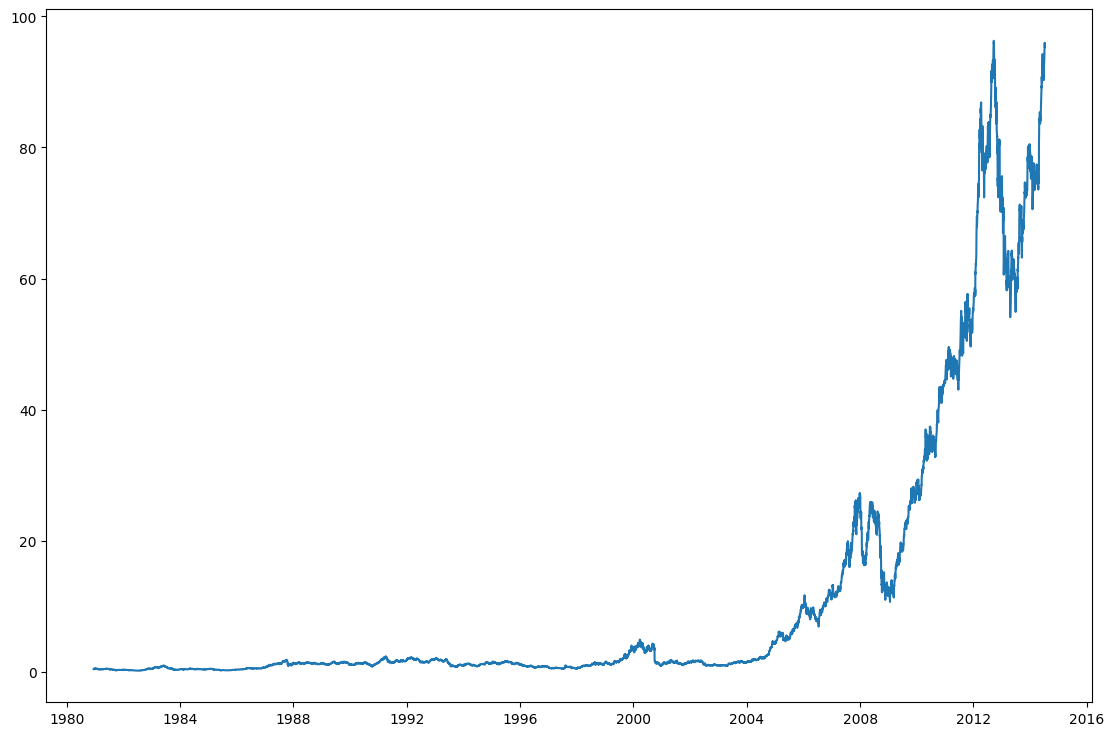

In [119]:
import matplotlib.pyplot as plt



plt.figure(figsize=(13.5, 9))
plt.plot(df['Adj Close'])
plt.show()

### BONUS: Create your own question and answer it.